In [1]:
import numpy as np
import slmsuite
from matplotlib import pyplot as plt
from slmsuite.holography.algorithms import Hologram

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import scipy.constants as con
from PIL import Image
from math import sin, pi as π
from slmsuite.holography.toolbox import _process_grid
from scipy.fft import fft2, fftshift,ifft2,ifftshift

d:\py\Python3\lib\site-packages\slmsuite\holography\algorithms.py:72: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


cupy not installed. Using numpy.


Here is the data processing program for my first test setup.  
The optical path and setup picture can be find in my first presentation powerpoint.

The following is for putting different phases on the SLM's screen.

In [53]:
#loading the slm-200
from slmsuite.hardware.slms.santec import Santec
Santec.info(verbose=True)
#set wavelength to the correct value
slm = Santec(slm_number=1, display_number=2, wav_um=.730, settle_time_s=.3)

Displays detected by Santec
display_number, display_name:
1,  ,CMN,8C02,0
2,  LCOS-SLM,SOC,8001,2018021001
Santec slm_number=1 initializing... success
Looking for display_number=2... success
Opening LCOS-SLM,SOC,8001,2018021001... success


In [55]:
#load vendor-provided wavefront calibraiton file
slm.load_vendor_phase_correction(
 file_path='e:\A_my project in Seattle\project\A_intensity generator\slm_initiate\Wavefront_correction_Data_adjust(730nm).csv', 
 smooth=True
)

array([[6.20917425, 6.22221249, 6.25956724, ..., 3.87552549, 3.83912854,
        3.82641519],
       [6.21395414, 6.22699199, 6.26434521, ..., 3.87779568, 3.84139794,
        3.82868426],
       [6.22761026, 6.24064661, 6.27799452, ..., 3.88427311, 3.84787331,
        3.83515872],
       ...,
       [5.97203517, 5.98373593, 6.01722459, ..., 0.40749883, 0.36318617,
        0.34772741],
       [5.96161218, 5.97331931, 6.00682154, ..., 0.39903215, 0.35470634,
        0.33924281],
       [5.95796097, 5.96967046, 6.0031777 , ..., 0.39606699, 0.3517369 ,
        0.33627182]])

In [56]:
phases = np.linspace(0, 2 * np.pi, 60)
phase_set = [np.full((1200, 1920), phase) for phase in phases]

In [176]:
slm.write(phase_set[59])

array([[ 12,   9,   3, ..., 392, 398, 400],
       [ 11,   9,   3, ..., 392, 397, 400],
       [  9,   6,   0, ..., 390, 396, 398],
       ...,
       [ 50,  48,  43, ..., 957, 964, 967],
       [ 52,  50,  45, ..., 958, 966, 968],
       [ 53,  51,  45, ..., 959, 966, 969]], dtype=uint16)


Once you've collected all the data you have, you can start the data processing.

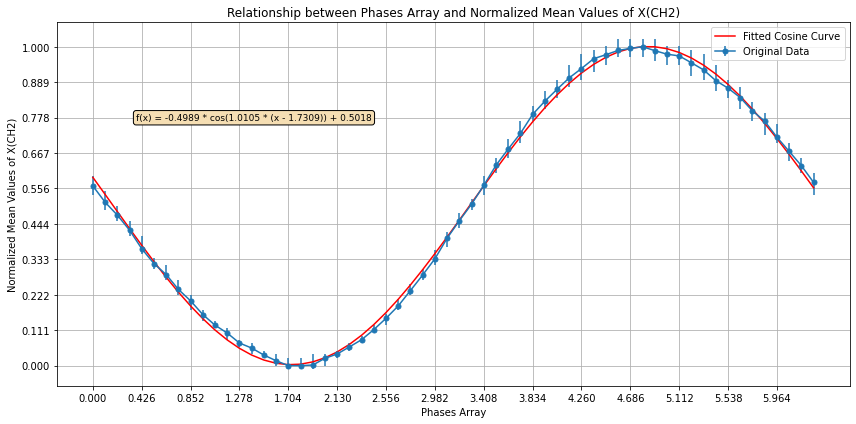

In [181]:
# Plot the normalized intensity for different phases with error bars

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

folder_path = r'E:\A_my project in Seattle\project\A3_eliminate the phase noise\data_corrected_1'

csv_files = [f"{i}.csv" for i in range(0, 60)]  

mean_col3_values = []
max_col3_values = []
min_col3_values = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, header=[0, 1])
    
    # Calculate mean, max, and min for column 3
    mean_col3 = df['X(CH2)', 'Volt'].mean()
    max_col3 = df['X(CH2)', 'Volt'].max()
    min_col3 = df['X(CH2)', 'Volt'].min()
    
    mean_col3_values.append(mean_col3)
    max_col3_values.append(max_col3)
    min_col3_values.append(min_col3)

mean_col3_values = np.array(mean_col3_values)
positive_errors = np.array(max_col3_values) - mean_col3_values
negative_errors = mean_col3_values - np.array(min_col3_values)

mean_col3_values_normalized = (mean_col3_values - np.min(mean_col3_values)) / (np.max(mean_col3_values) - np.min(mean_col3_values))
positive_errors_normalized = positive_errors / (np.max(mean_col3_values) - np.min(mean_col3_values))
negative_errors_normalized = negative_errors / (np.max(mean_col3_values) - np.min(mean_col3_values))

def cosine_func(x, A, B, C, D):
    return A * np.cos(B * (x - C)) + D

# Fit the data to the cosine function
params, _ = curve_fit(cosine_func, phases, mean_col3_values_normalized)
fitted_data = cosine_func(phases, *params)

plt.figure(figsize=(12, 6))
# Plot the original data with error bars
plt.errorbar(phases, mean_col3_values_normalized, yerr=[negative_errors_normalized, positive_errors_normalized], fmt='o-', markersize=5, label='Original Data')
plt.plot(phases, fitted_data, 'r-', label='Fitted Cosine Curve')

cosine_expression = f"f(x) = {params[0]:.4f} * cos({params[1]:.4f} * (x - {params[2]:.4f})) + {params[3]:.4f}"
plt.text(0.1, 0.75, cosine_expression, transform=plt.gca().transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat"))

num_x_ticks = 15
x_tick_interval = len(phases) // num_x_ticks
plt.xticks(phases[::x_tick_interval])
num_y_ticks = 10
y_tick_interval = len(mean_col3_values_normalized) // num_y_ticks
plt.yticks(np.linspace(min(mean_col3_values_normalized), max(mean_col3_values_normalized), num_y_ticks))
plt.xlabel('Phases Array')
plt.ylabel('Normalized Mean Values of X(CH2)')
plt.title('Relationship between Phases Array and Normalized Mean Values of X(CH2)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


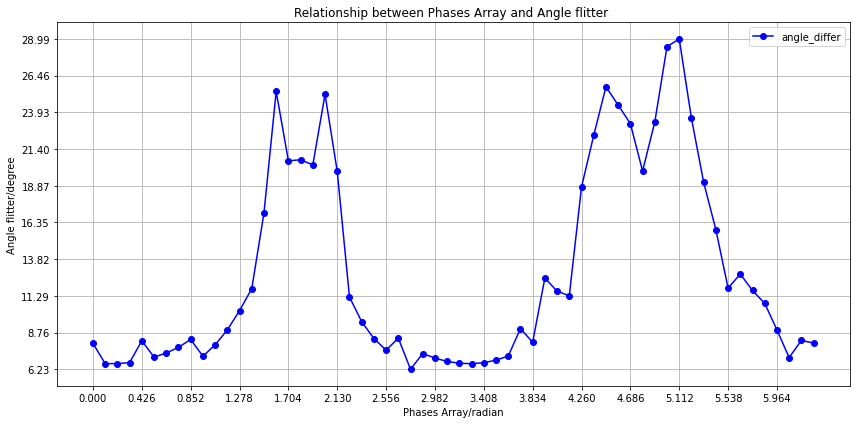

In [182]:
#Plot the angle jitter for different phases

from numpy import cos, arccos,sin
angle_variation = []

A, B, C, D = params  # Extracting the fitted parameters

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, header=[0, 1])
    
    mean_col2 = df['X(CH1)', 'Volt'].mean()
    df['X(CH1) Processed'] = df['X(CH1)', 'Volt'] - mean_col2
    df['X(CH2) Processed'] = df['X(CH2)', 'Volt']
    df['Difference'] = df['X(CH2) Processed'] - df['X(CH1) Processed']
    df['Difference'] = (df['Difference'] - np.min(mean_col3_values)) / (np.max(mean_col3_values) - np.min(mean_col3_values))
    
    sine_value = A * sin(B * (df['Difference'] - C))
    angle = arccos(np.clip((df['Difference'] - D) / A, -1, 1)) / B + C
    angle[sine_value < 0] = 2 * np.pi - angle[sine_value < 0]
    
    angle = angle / np.pi * 180  # Convert to degrees
    
    max_angle = angle.max()
    min_angle = angle.min()
    angle_differ = max_angle - min_angle
    angle_variation.append(angle_differ)

plt.figure(figsize=(12, 6))
plt.plot(phases, angle_variation, 'o-', color='blue', label='angle_differ')
num_x_ticks = 15
x_tick_interval = len(phases) // num_x_ticks
plt.xticks(phases[::x_tick_interval])
num_y_ticks = 10
y_tick_interval = len(angle_variation) // num_y_ticks
plt.yticks(np.linspace(min(angle_variation), max(angle_variation), num_y_ticks))
plt.xlabel('Phases Array/radian')
plt.ylabel('Angle flitter/degree')
plt.title('Relationship between Phases Array and Angle flitter ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

    

Define fidelity as $F = (1 + cos(\delta\phi))/2 $

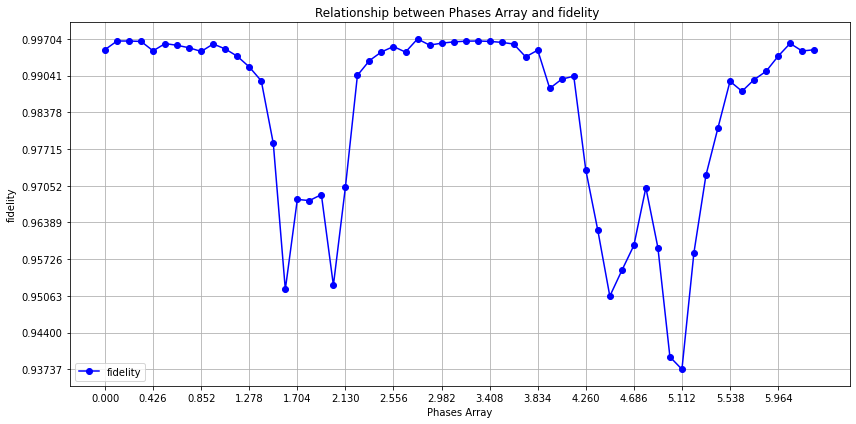

: 

In [183]:
#Plot the fidelity for different phase

angle_radian = np.array(angle_variation) / 180 * np.pi

F = np.array((1+ np.cos(angle_radian))/2) 
plt.figure(figsize=(12, 6))
plt.plot(phases, F, 'o-', color='blue', label='fidelity')
num_x_ticks = 15
x_tick_interval = len(phases) // num_x_ticks
plt.xticks(phases[::x_tick_interval])
num_y_ticks = 10
y_tick_interval = len(F) // num_y_ticks
plt.yticks(np.linspace(min(F), max(F), num_y_ticks))
plt.xlabel('Phases Array')
plt.ylabel('fidelity')
plt.title('Relationship between Phases Array and fidelity ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

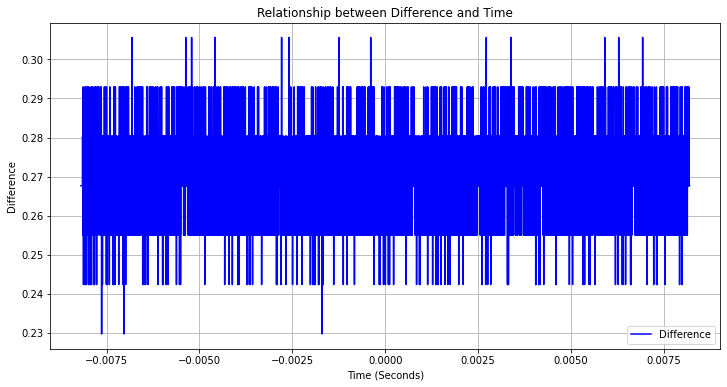

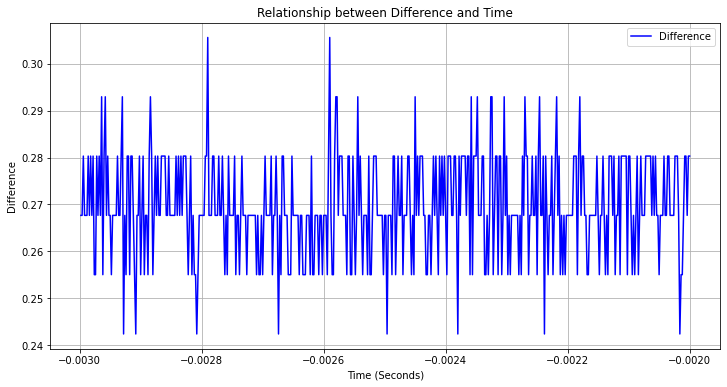

In [41]:
import pandas as pd

df = pd.read_csv('e:/A_my project in Seattle/project/A3_eliminate the phase noise/data_corrected_0/4.csv', header=[0, 1])

df.head()
# Calculate the mean for column 2 and column 3
mean_col2 = df['X(CH1)', 'Volt'].mean()
mean_col3 = df['X(CH2)', 'Volt'].mean()

# Subtract column 2 and column 3 by their respective means
df['X(CH1) Processed'] = df['X(CH1)', 'Volt']  - mean_col2
df['X(CH2) Processed'] = df['X(CH2)', 'Volt']

import matplotlib.pyplot as plt

# Calculate the difference between the processed data
df['Difference'] =  df['X(CH2) Processed']-df['X(CH1) Processed']
# df['Difference'] =  df['X(CH2) Processed']
df['Difference'] = (df['Difference'] - np.min(mean_col3_values)) / (np.max(mean_col3_values) - np.min(mean_col3_values))

# Plot the relationship between the result (difference) and time
plt.figure(figsize=(12, 6))
plt.plot(df['Time', 'Second'], df['Difference'], label='Difference', color='blue')

plt.xlabel('Time (Seconds)')
plt.ylabel('Difference')
plt.title('Relationship between Difference and Time')
plt.legend()
plt.grid(True)
plt.show()

filtered_df = df[(df['Time', 'Second'] >= -3e-3) & (df['Time', 'Second'] <= -2e-3)]
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Time', 'Second'], filtered_df['Difference'], label='Difference', color='blue')

plt.xlabel('Time (Seconds)')
plt.ylabel('Difference')
plt.title('Relationship between Difference and Time')
plt.legend()
plt.grid(True)
plt.show()



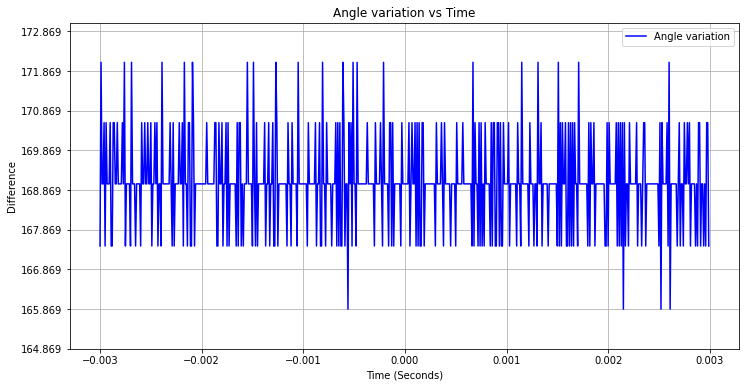

In [15]:
from numpy import cos, arccos

angle = arccos((df['Difference'] - params[3]) / params[0])/params[1]+params[2]
angle = angle / np.pi * 180
plt.figure(figsize=(12, 6))
plt.plot(df['Time', 'Second'], angle, label='Angle variation', color='blue')

plt.xlabel('Time (Seconds)')
plt.ylabel('Difference')
plt.ylim(min(angle)-1, max(angle)+1)
plt.yticks(np.arange(min(angle)-1, max(angle)+1, 1))
plt.title('Angle variation vs Time')
plt.legend()
plt.grid(True)
plt.show()
